## Treinamento de modelo v1

Fonte da arquitetura do modelo: https://repositorio.ufsc.br/handle/123456789/254052

### Arquitetura do Modelo MLP

Duas camadas ocultas:
- 41 neuronios em cada camada oculta (é o mesmo numero de atributos da base utilizada, nesse caso a NSLKDD tem 41)
- Função de ativação tanh nos neuronios das camadas ocultas

Camada de saida:
- 2 neuronios (nesse caso foi utilizada para classificacao binária)
- Função de ativação softmax nos neuronios da camada de saida

Treinamento:
- Foram utilizadas 100 epocas
- Foi utilizado otimizador adam
- Foi utilizada função loss sparse_categorical_crossentropy

### Pré-processamento dos dados

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from keras.layers import Dense
import shap

c:\Users\mathe\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Fonte para o pré-processamento dos dados do dataset NSL-KDD:
# https://www.kaggle.com/code/ajeffreyrufus/network-intrusion-detection-using-ml-99-accuracy
train_data = pd.read_csv("../../data/raw/NSL-KDD/KDDTrain+.csv", header=None)
test_data = pd.read_csv("../../data/raw/NSL-KDD/KDDTest+.csv", header=None)

In [4]:
# Carregar dataset
columns = [
    "duration",  # Duração da conexão em segundos
    "protocol_type",  # Tipo de protocolo utilizado (tcp, udp, icmp)
    "service",  # Serviço de destino (ex: http, ftp, telnet)
    "flag",  # Estado da conexão TCP (ex: SF - conexão finalizada sem erro)
    "src_bytes",  # Bytes enviados da origem para o destino
    "dst_bytes",  # Bytes recebidos pelo destino
    "land",  # 1 se origem e destino são iguais (ataque land), 0 caso contrário
    "wrong_fragment",  # Número de fragmentos incorretos
    "urgent",  # Número de pacotes urgentes
    "hot",  # Número de acessos a diretórios sensíveis do sistema
    "num_failed_logins",  # Número de tentativas de login falhas
    "logged_in",  # 1 se o login foi bem-sucedido, 0 caso contrário
    "num_compromised",  # Número de condições que comprometem a segurança do sistema
    "root_shell",  # 1 se um shell root foi obtido, 0 caso contrário
    "su_attempted",  # 1 se houve tentativa de usar `su` para privilégio, 0 caso contrário
    "num_root",  # Número de acessos como root
    "num_file_creations",  # Número de operações de criação de arquivos
    "num_shells",  # Número de shells abertos
    "num_access_files",  # Número de acessos a arquivos críticos do sistema
    "num_outbound_cmds",  # Número de comandos outbound em conexão FTP (sempre 0 no dataset)
    "is_host_login",  # 1 se login foi feito no host, 0 caso contrário
    "is_guest_login",  # 1 se login foi feito como convidado, 0 caso contrário
    "count",  # Número de conexões para o mesmo host nas últimas 2 segundos
    "srv_count",  # Número de conexões para o mesmo serviço nas últimas 2 segundos
    "serror_rate",  # Taxa de conexões com erro de sincronização (SYN)
    "srv_serror_rate",  # Taxa de conexões com erro de sincronização no mesmo serviço
    "rerror_rate",  # Taxa de conexões rejeitadas
    "srv_rerror_rate",  # Taxa de conexões rejeitadas no mesmo serviço
    "same_srv_rate",  # Taxa de conexões para o mesmo serviço
    "diff_srv_rate",  # Taxa de conexões para serviços diferentes
    "srv_diff_host_rate",  # Taxa de conexões para diferentes hosts no mesmo serviço
    "dst_host_count",  # Número de conexões para o mesmo destino
    "dst_host_srv_count",  # Número de conexões para o mesmo serviço no destino
    "dst_host_same_srv_rate",  # Taxa de conexões para o mesmo serviço no destino
    "dst_host_diff_srv_rate",  # Taxa de conexões para serviços diferentes no destino
    "dst_host_same_src_port_rate",  # Taxa de conexões para o mesmo destino usando a mesma porta de origem
    "dst_host_srv_diff_host_rate",  # Taxa de conexões para diferentes hosts no mesmo serviço no destino
    "dst_host_serror_rate",  # Taxa de conexões com erro de sincronização no destino
    "dst_host_srv_serror_rate",  # Taxa de conexões com erro de sincronização no mesmo serviço no destino
    "dst_host_rerror_rate",  # Taxa de conexões rejeitadas no destino
    "dst_host_srv_rerror_rate",  # Taxa de conexões rejeitadas no mesmo serviço no destino
    "attack",  # Tipo de ataque ou "normal" se for tráfego legítimo
    "level",  # Gravidade do ataque (normalmente não usado)
]

In [5]:
train_data.columns = columns
test_data.columns = columns

In [6]:
full_data = pd.concat([train_data, test_data], ignore_index=True)

# Coding categorial variables
label_encoders = {}
for column in ["protocol_type", "service", "flag"]:
    le = LabelEncoder()
    full_data[column] = le.fit_transform(full_data[column])
    label_encoders[column] = le

In [7]:
X = full_data.drop(["attack", "level"], axis=1)
y = full_data["attack"].apply(lambda x: 0 if x == "normal" else 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Combine unique labels from both y_train and y_test
all_labels = pd.concat([y_train, y_test]).unique()

# Encode the target variable (attack) using LabelEncoder
# attack_encoder = LabelEncoder()
# attack_encoder.fit(all_labels)

# Transform the target variables
# y_train_encoded = attack_encoder.transform(y_train)
# y_test_encoded = attack_encoder.transform(y_test)

# One-hot encode the target variable
# num_classes = len(attack_encoder.classes_)
# y_train_cat = y_train_encoded
# y_test_cat = y_test_encoded
# y_train_cat = y_train
# y_test_cat = y_test

### Definição e Treinamento do Modelo

In [9]:
# Model Architecture
model = Sequential(
    [
        Dense(X_train.shape[1], activation="tanh", input_shape=(X_train.shape[1],)),
        Dense(X_train.shape[1], activation="tanh"),
        Dense(2, activation="softmax"),
    ]
)

model.summary()

c:\Users\mathe\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 41)             │         1,722 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41)             │         1,722 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            84 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,528 (13.78 KB)

 Trainable params: 3,528 (13.78 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile model
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Fit model
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
)

loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy}")

Epoch 1/100
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 4s 921us/step - accuracy: 0.9456 - loss: 0.1337 - val_accuracy: 0.9793 - val_loss: 0.0594
Epoch 2/100
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 899us/step - accuracy: 0.9790 - loss: 0.0588 - val_accuracy: 0.9819 - val_loss: 0.0517
Epoch 3/100
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 900us/step - accuracy: 0.9821 - loss: 0.0485 - val_accuracy: 0.9856 - val_loss: 0.0446
Epoch 4/100
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 900us/step - accuracy: 0.9852 - loss: 0.0423 - val_accuracy: 0.9839 - val_loss: 0.0423
Epoch 5/100
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 887us/step - accuracy: 0.9872 - loss: 0.0366 - val_accuracy: 0.9848 - val_loss: 0.0414
Epoch 6/100
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 897us/step - accuracy: 0.9873 - loss: 0.0359 - val_accuracy: 0.9846 - val_loss: 0.0431
Epoch 7/100
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 898us/step - accuracy: 0.9887 - loss: 0.0329 - val_accuracy: 0.9873 - val_loss: 0.0360
Epoch 8/100
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 3s 889us/step - accuracy: 

In [11]:
model.save('model_mlp.keras')

929/929 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     15450
           1       0.99      0.99      0.99     14254

    accuracy                           0.99     29704
   macro avg       0.99      0.99      0.99     29704
weighted avg       0.99      0.99      0.99     29704



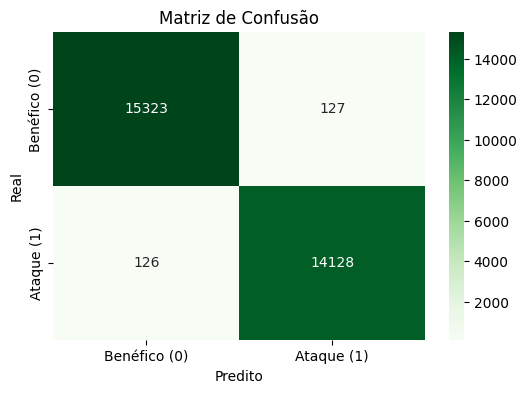

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(X_test_scaled), axis=1)

cm = confusion_matrix(y_test, y_pred)

print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Benéfico (0)", "Ataque (1)"],
    yticklabels=["Benéfico (0)", "Ataque (1)"],
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

929/929 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step
929/929 ━━━

C:\Users\mathe\AppData\Local\Temp\ipykernel_8420\3223567872.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


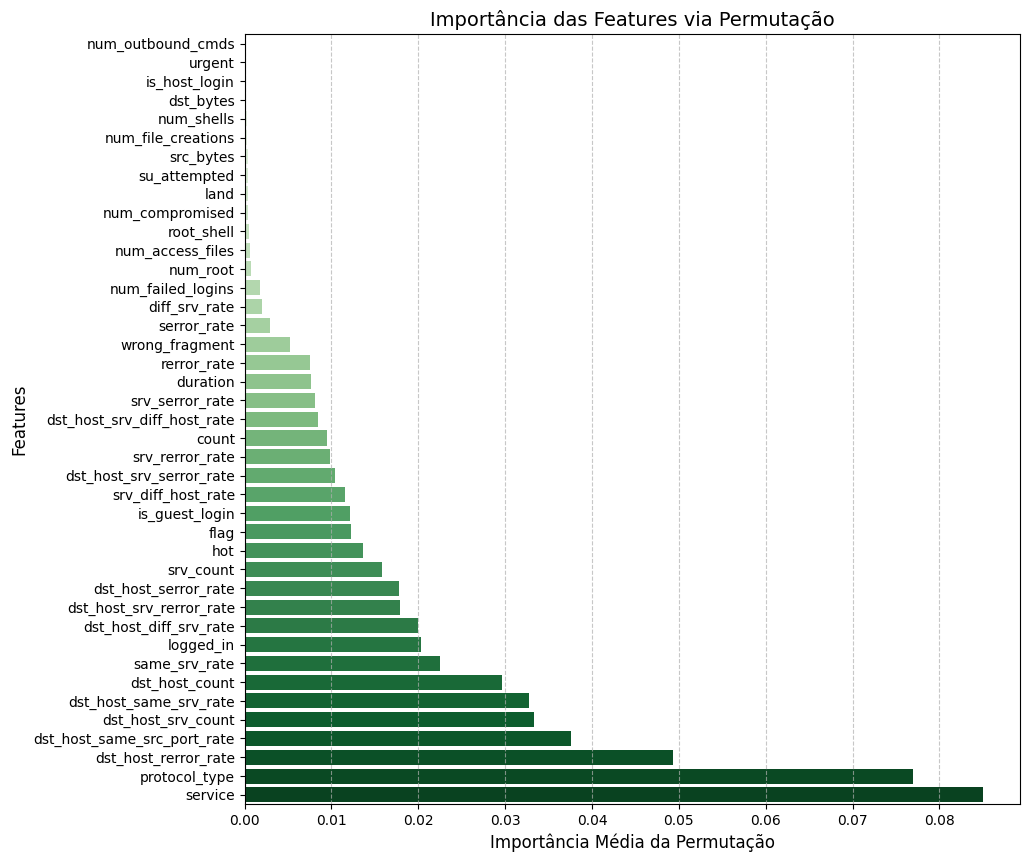

In [13]:
# Importância global das features com Permutation Importance do sklearn

from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin


class KerasWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
        y_pred = self.model.predict(X)
        return y_pred.argmax(axis=1)


model_wrapper = KerasWrapper(model)

perm_importance = permutation_importance(
    model_wrapper, X_test_scaled, y_test, scoring="accuracy"
)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 10))
sns.barplot(
    x=perm_importance.importances_mean[sorted_idx],
    y=X_test.columns[sorted_idx],
    palette="Greens",
    orient="h",
)

plt.xlabel("Importância Média da Permutação", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Importância das Features via Permutação", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
# SHAP declaration
background = shap.sample(X_test_scaled, 1000)
explainer = shap.KernelExplainer(model, background) # verificar estratégia de amostragem
shap_values = explainer.shap_values(X_test_scaled[:1000])

# background = shap.sample(X_test_scaled, 100)
# explainer = shap.KernelExplainer(model.predict, background)
# shap_values = explainer.shap_values(X_test_scaled[:1000])

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  3%|▎         | 27/1000 [00:20<12:46,  1.27it/s]

In [ ]:
feature_names = X_test.columns.tolist()

import joblib

joblib.dump({
    "model": "MLP",
    # "shap_values": shap_values, # antes
    "shap_values": shap_values[:, :, 1],
    "X_test": X_test_scaled[:1000],
    "features": feature_names
}, "shap_mlp.pkl")

['shap_mlp.pkl']

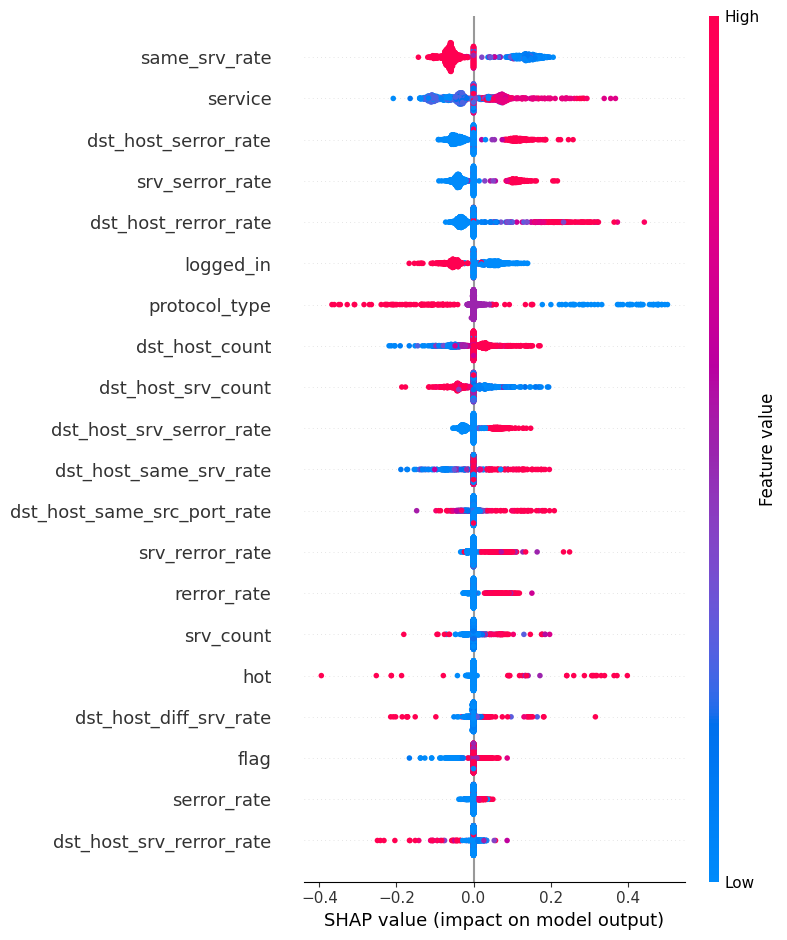

In [ ]:
# SHAP - Feature Global Importance - Attack traffic Predicted
shap_values = shap_values[:, :, 1]

shap.summary_plot(shap_values, X_test_scaled[:1000], feature_names=X_test.columns)

In [ ]:
background = shap.sample(X_train_scaled, 100)


predict_fn = lambda x: model.predict(x, verbose=0)


explainer = shap.KernelExplainer(predict_fn, background)


X_explain = X_test_scaled[:1000]
shap_values = explainer.shap_values(X_explain)  # lista de [classe 0, classe 1]

shap_attack = shap_values[1]

feature_names = X_train.columns.tolist()
X_explain_df = pd.DataFrame(X_explain, columns=feature_names)

joblib.dump({
    "model": "MLP",
    "shap_values": shap_attack,
    "X_test": X_explain_df,
    "features": feature_names
}, "shap_exports/shap_mlp.pkl")

100%|██████████| 1000/1000 [1:24:19<00:00,  5.06s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'shap_exports/shap_mlp.pkl'

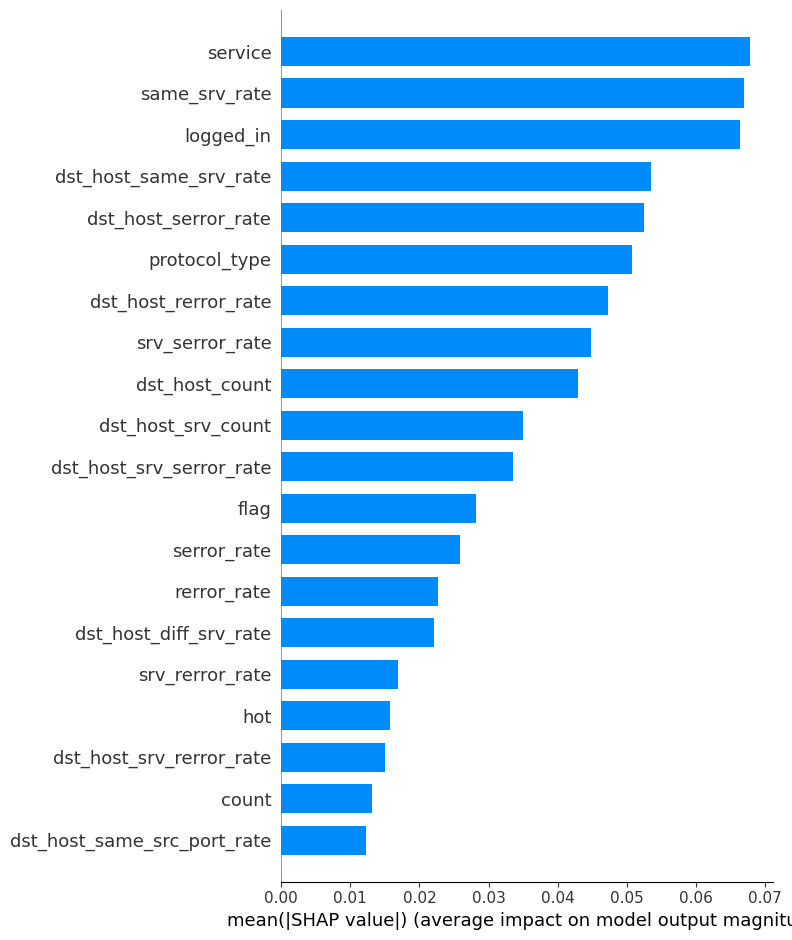

In [ ]:
# SHAP - Feature Global Importance - Normal traffic Predicted
# shap_values = shap_values[:, :, 0]

# shap.summary_plot(shap_values, X_test_scaled[:1000], feature_names=X_test.columns)

shap.summary_plot(
    shap_values, X_test_scaled[:1000], plot_type="bar", feature_names=X_test.columns
)

In [ ]:
import joblib

joblib.dump({
    "model": "MLP",
    "shap_values": shap_values,
    "X_test": X_test,
    "features": X_test.columns.tolist()
}, "shap_rf.pkl")